<a href="https://colab.research.google.com/github/MacsEli/DocumentosDeClase/blob/main/Colab_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set()

#### Funcion para corrplot

In [ ]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
          corr['x'], corr['y'],
          color=corr['value'], color_range=[-1, 1],
          palette=sns.diverging_palette(20, 220, n=256),
          size=corr['value'].abs(), size_range=[0,1],
          marker=marker,
          x_order=data.columns,
          y_order=data.columns[::-1],
          size_scale=size_scale
      )

# PCA

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/ReynaldoMR3/clases_ih/main/segmentation%20data.csv", index_col=0)

In [ ]:
data.head()
#sex, 0 female, 1 male
#marital status, 0 single, 1 not-single
#education 0 - other or unknown,1 - high school, 2- university, 3- graduate school
#ocupation 0- unemployed , 1 - employeed, 2 - manager, self-employeed
#settlement size - 0 small city, 1 mid size, 2 big city

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [ ]:
data.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000
mean,0.457,0.496,35.909,1.038,120954.419,0.810,0.739
std,0.498,0.500,11.719,0.600,38108.825,0.639,0.813
min,0.000,0.000,18.000,0.000,35832.000,0.000,0.000
25%,0.000,0.000,27.000,1.000,97663.250,0.000,0.000
50%,0.000,0.000,33.000,1.000,115548.500,1.000,1.000
75%,1.000,1.000,42.000,1.000,138072.250,1.000,1.000
max,1.000,1.000,76.000,3.000,309364.000,2.000,2.000


In [ ]:
data.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000,0.567,-0.183,0.245,-0.195,-0.202,-0.301
Marital status,0.567,1.000,-0.213,0.374,-0.074,-0.029,-0.097
Age,-0.183,-0.213,1.000,0.655,0.341,0.108,0.120
Education,0.245,0.374,0.655,1.000,0.233,0.065,0.035
Income,-0.195,-0.074,0.341,0.233,1.000,0.680,0.491
Occupation,-0.202,-0.029,0.108,0.065,0.680,1.000,0.572
Settlement size,-0.301,-0.097,0.120,0.035,0.491,0.572,1.000


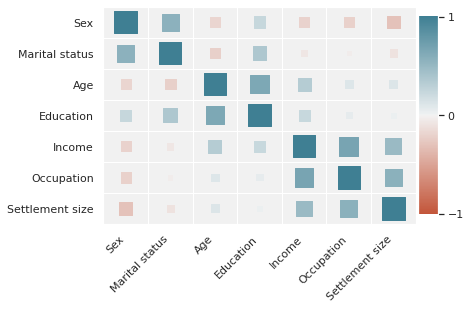

In [ ]:
corrplot(data.corr())

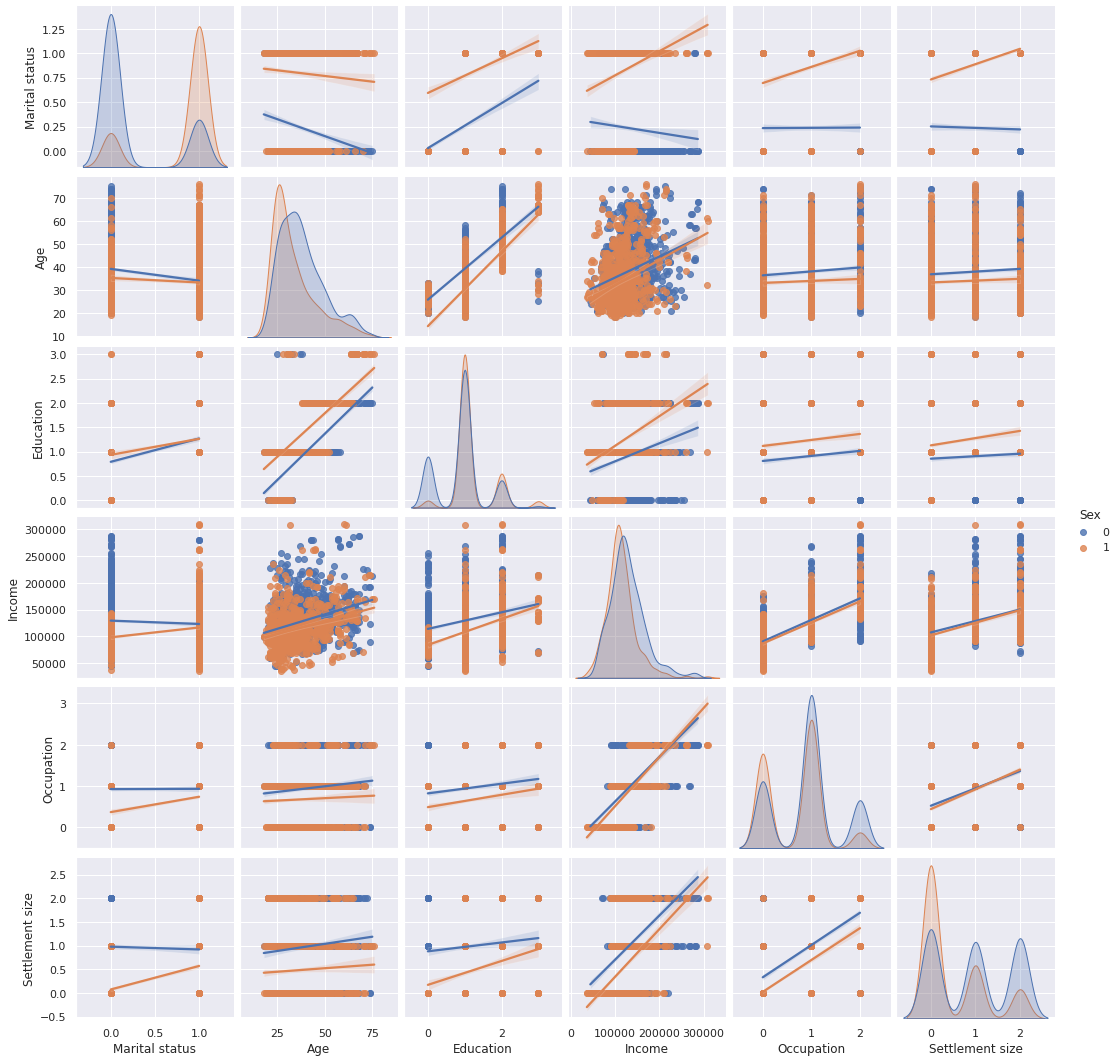

In [ ]:
sns.pairplot(data, hue='Sex', kind='reg')

In [ ]:
# standardization
scaler = StandardScaler()
norm_data = scaler.fit_transform(data)

In [ ]:
type(norm_data)

numpy.ndarray

In [ ]:
df = pd.DataFrame(norm_data, index=data.index, columns=data.columns)
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,-0.917,-0.993,2.654,1.604,0.098,0.297,1.552
100000002,1.090,1.007,-1.187,-0.063,0.783,0.297,1.552
100000003,-0.917,-0.993,1.117,-0.063,-0.833,-1.270,-0.910
100000004,-0.917,-0.993,0.776,-0.063,1.328,0.297,0.321
100000005,-0.917,-0.993,1.459,-0.063,0.737,0.297,0.321


In [ ]:
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000
mean,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.917,-0.993,-1.529,-1.731,-2.234,-1.270,-0.910
25%,-0.917,-0.993,-0.760,-0.063,-0.611,-1.270,-0.910
50%,-0.917,-0.993,-0.248,-0.063,-0.142,0.297,0.321
75%,1.090,1.007,0.520,-0.063,0.449,0.297,0.321
max,1.090,1.007,3.422,3.272,4.945,1.863,1.552


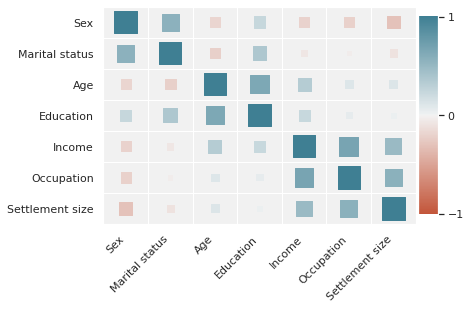

In [ ]:
corrplot(df.corr())

In [ ]:
# usando PCA
pca = PCA()
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

In [ ]:
sum(pca.explained_variance_ratio_)

1.0

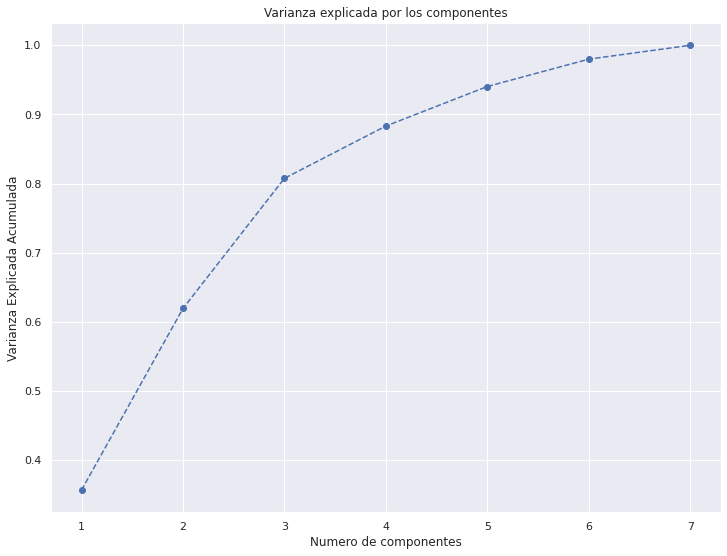

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle="--")
plt.title("Varianza explicada por los componentes")
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada Acumulada"); #Regla de oro es quedarnos con el 80% de la varianza

In [ ]:
pca = PCA(n_components= 3)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Resultado de PCA
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [ ]:
df_pca_comp = pd.DataFrame(data=pca.components_,
                           columns = df.columns.values,
                           index = ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3']
                           )

df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Componente Principal 1,-0.315,-0.192,0.326,0.157,0.525,0.492,0.465
Componente Principal 2,0.458,0.513,0.312,0.640,0.125,0.015,-0.070
Componente Principal 3,-0.293,-0.442,0.610,0.276,-0.166,-0.396,-0.296


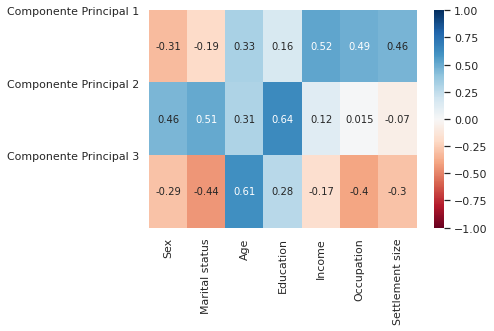

In [ ]:
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap='RdBu',
            annot=True
            )
plt.yticks([0,1,2],
           ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3']
           );

In [ ]:
df_transform = pca.transform(df)
df_transform[:10]

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       [ 1.71431626, -0.5799265 ,  0.73073109],
       [ 1.62674455, -0.44049553,  1.24490888],
       [-0.27473365, -0.87107008,  1.31015184],
       [ 1.72950371, -0.41606896,  1.21245413],
       [ 2.51037734, -0.75125641, -0.50491655],
       [ 0.41989134,  1.93611481,  2.20911747],
       [ 1.09872884,  0.11113129, -1.30656149]])

In [ ]:
data_pca = pd.DataFrame(df_transform, index=df.index, columns=['C1', 'C2', 'C3'])
data_pca.head()

,C1,C2,C3
ID,,,
100000001,2.515,0.834,2.175
100000002,0.345,0.598,-2.212
100000003,-0.651,-0.680,2.280
100000004,1.714,-0.580,0.731
100000005,1.627,-0.440,1.245


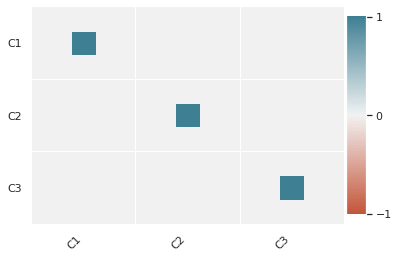

In [ ]:
corrplot(data_pca.corr())

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [ ]:
print(digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [ ]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [ ]:
def plot_digits(data):
  fig, axes = plt.subplots(4, 10, figsize=(10,4),
                           subplot_kw={'xticks':[], 'yticks':[]},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1)
                           )
  
  for i, ax in enumerate(axes.flat):
    ax.imshow(data[i].reshape(8,8),
              cmap='binary', interpolation='nearest'
              )

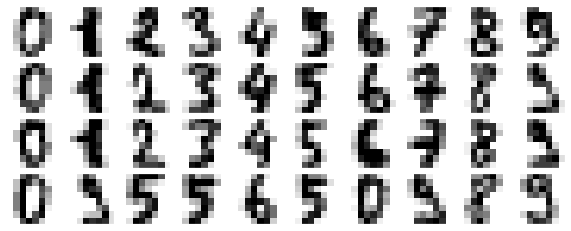

In [ ]:
plot_digits(digits.data)

In [ ]:
pca = PCA().fit(digits.data)
pca.n_components_

64

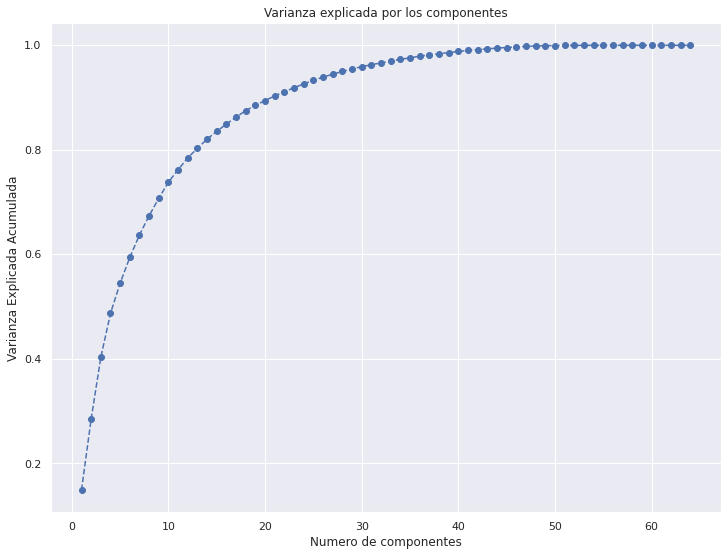

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(range(1,65), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle="--")
plt.title("Varianza explicada por los componentes")
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada Acumulada"); #Regla de oro es quedarnos con el 80% de la varianza

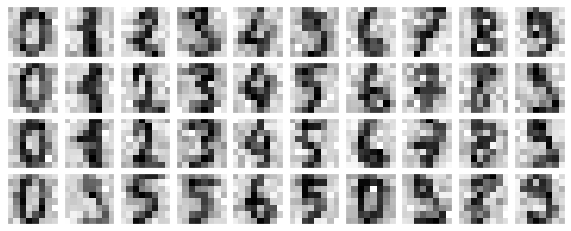

In [ ]:
np.random.seed = 42
noise = np.random.normal(digits.data, 2)
plot_digits(noise)

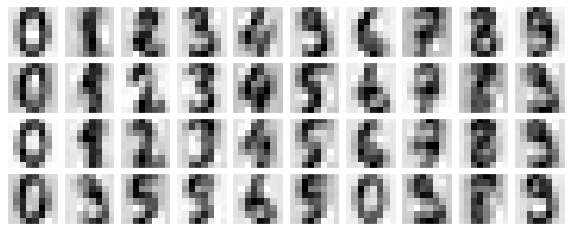

In [ ]:
pca = PCA(n_components=10).fit(noise)
componentes = pca.transform(noise)
filtro = pca.inverse_transform(componentes)

plot_digits(filtro)

In [ ]:
pca.components_

array([[-1.04776282e-02, -1.68036132e-02, -2.17993808e-01,
        -1.24976001e-01, -3.43122916e-02, -1.03311276e-01,
        -5.41734588e-03,  4.18773243e-03, -7.19942969e-04,
        -1.18641292e-01, -2.44949263e-01,  1.51247347e-01,
        -4.83057112e-02, -2.17999954e-01, -1.07768995e-02,
         1.82810569e-03,  2.42821552e-03, -7.42434163e-02,
         9.27671169e-02,  2.05811750e-01, -1.73843709e-01,
        -1.67978826e-01,  3.20081949e-02, -2.36506047e-03,
        -2.16740233e-03,  7.31721050e-02,  2.63262935e-01,
        -4.33184938e-02, -2.17669907e-01, -4.09944844e-02,
         5.41066961e-02, -7.78172787e-04,  1.31118141e-03,
         1.70766444e-01,  3.72819113e-01,  1.56183034e-01,
         7.54113331e-02,  5.43888808e-02,  2.98264319e-02,
        -1.85647078e-03,  8.15727530e-03,  1.09709072e-01,
         2.96764397e-01,  2.40272898e-01,  2.04945966e-01,
         1.52844429e-02, -2.98896170e-02, -6.69807010e-04,
         3.16675151e-03, -5.95460008e-03, -5.53939795e-0

In [ ]:
pca.n_components_

21